This project aims to create a neural network capable of estimating DoA from telecommunications signals.

To do so, the training dataset consists of In-Phase and Quadrature (IQ) samples and Angle of Arrival (AoA) measures.
IQ samples consists

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import layers, models
import os
from keras.optimizers import Adam

In [2]:
# Set dataset path variable
signals_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Signalsbluetooth_signals_dataset_2024-03-07_23-04-13.csv"
)
# Set dataset path variable
angles_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Anglesbluetooth_signals_dataset_2024-03-07_23-04-13.csv"
)

In [3]:
# Load dataset
signal_dataset = pd.read_csv(signals_dataset_path, header=None)
signals_dataset_transposed = signal_dataset.transpose()

angles_dataset = pd.read_csv(angles_dataset_path, header=None)

data = result_df = pd.concat([angles_dataset, signals_dataset_transposed], axis=1)

In [4]:
# Extract features (IQ samples) and labels (Angles)
X_complex_str = data.iloc[:, 1:].values.astype(str)
# Replace 'i' with 'j'
X_complex_str = np.char.replace(X_complex_str, 'i', 'j')
# Convert to np.complex128
X_complex_linear = X_complex_str.astype(np.complex128)
X_complex = X_complex_linear.reshape((X_complex_linear.shape[0],4,4))
y_str = data.iloc[:, 0].values

# Separate real and imaginary parts for features
X_cov_real = np.real(X_complex)
X_cov_imag = np.imag(X_complex)

# Combine real and imaginary parts into a single array for features
X_cov_combined = np.stack((X_cov_real, X_cov_imag), axis=-1)

# Convert string representations of complex numbers to actual complex values for labels
y = np.array([int(val) for val in y_str])

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cov_combined, y, test_size=0.2, shuffle=True)

In [5]:
from keras.models import Model
from keras.layers import Input

real_input = Input(shape = (4,4,1))
real_conv_1 = layers.Conv2D(filters=256, strides=(1, 1), kernel_size = (3,3), activation='linear')(real_input)
real_batch_norm_1 = layers.BatchNormalization()(real_conv_1)
real_max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(real_batch_norm_1)
real_flatten = layers.Flatten()(real_max_pool_1)


imag_input = Input(shape = (4,4,1))
imag_conv1 = layers.Conv2D(filters=256, strides=(1, 1), kernel_size = (3,3), activation='linear')(imag_input)
imag_batch_norm_1 = layers.BatchNormalization()(imag_conv1)
imag_max_pool1 = layers.MaxPooling2D(pool_size=(2,2))(imag_batch_norm_1)
imag_flatten = layers.Flatten()(imag_max_pool1)

merge = layers.Concatenate()([real_flatten,imag_flatten])

# Fully connected layer with 512 neurons, 'linear' activation function, and batch normalization
dense_1024 = layers.Dense(1024, activation='linear')(merge)
dropout_1 = layers.Dropout(0.5)(dense_1024)

# Fully connected layer with 256 neurons, 'linear' activation function, and batch normalization
dense_256 = layers.Dense(256, activation='linear')(dropout_1)
dropout_2 = layers.Dropout(0.5)(dense_256)

# Output layer with one value 'linear' activation function for categorical classification
output = layers.Dense(1, activation='linear')(dropout_2)

model = Model(inputs = [real_input, imag_input], outputs = output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print a summary of the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 4, 1)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4, 4, 1)]            0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 2, 2, 256)            2560      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 2, 2, 256)            2560      ['input_2[0][0]']             
                                                                                              

In [6]:
# # Model architecture
# model = models.Sequential()
# # Conv2D layer
# model.add(layers.Conv2D(filters=256, strides=(1, 1), kernel_size = (3,3), input_shape=X_train.shape[1:], activation='sigmoid'))
# model.add(layers.BatchNormalization())

# # Flatten the input for the fully connected layers
# model.add(layers.Flatten())

# # Fully connected layer with 512 neurons, 'relu' activation function, and batch normalization
# model.add(layers.Dense(1024, activation='linear'))
# model.add(layers.Dropout(0.5))

# # Fully connected layer with 256 neurons, 'linear' activation function, and batch normalization
# model.add(layers.Dense(256, activation='linear'))
# model.add(layers.Dropout(0.5))

# # Output layer with one value 'linear' activation function for categorical classification
# model.add(layers.Dense(1, activation='linear'))

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# # Print a summary of the model architecture
# model.summary()

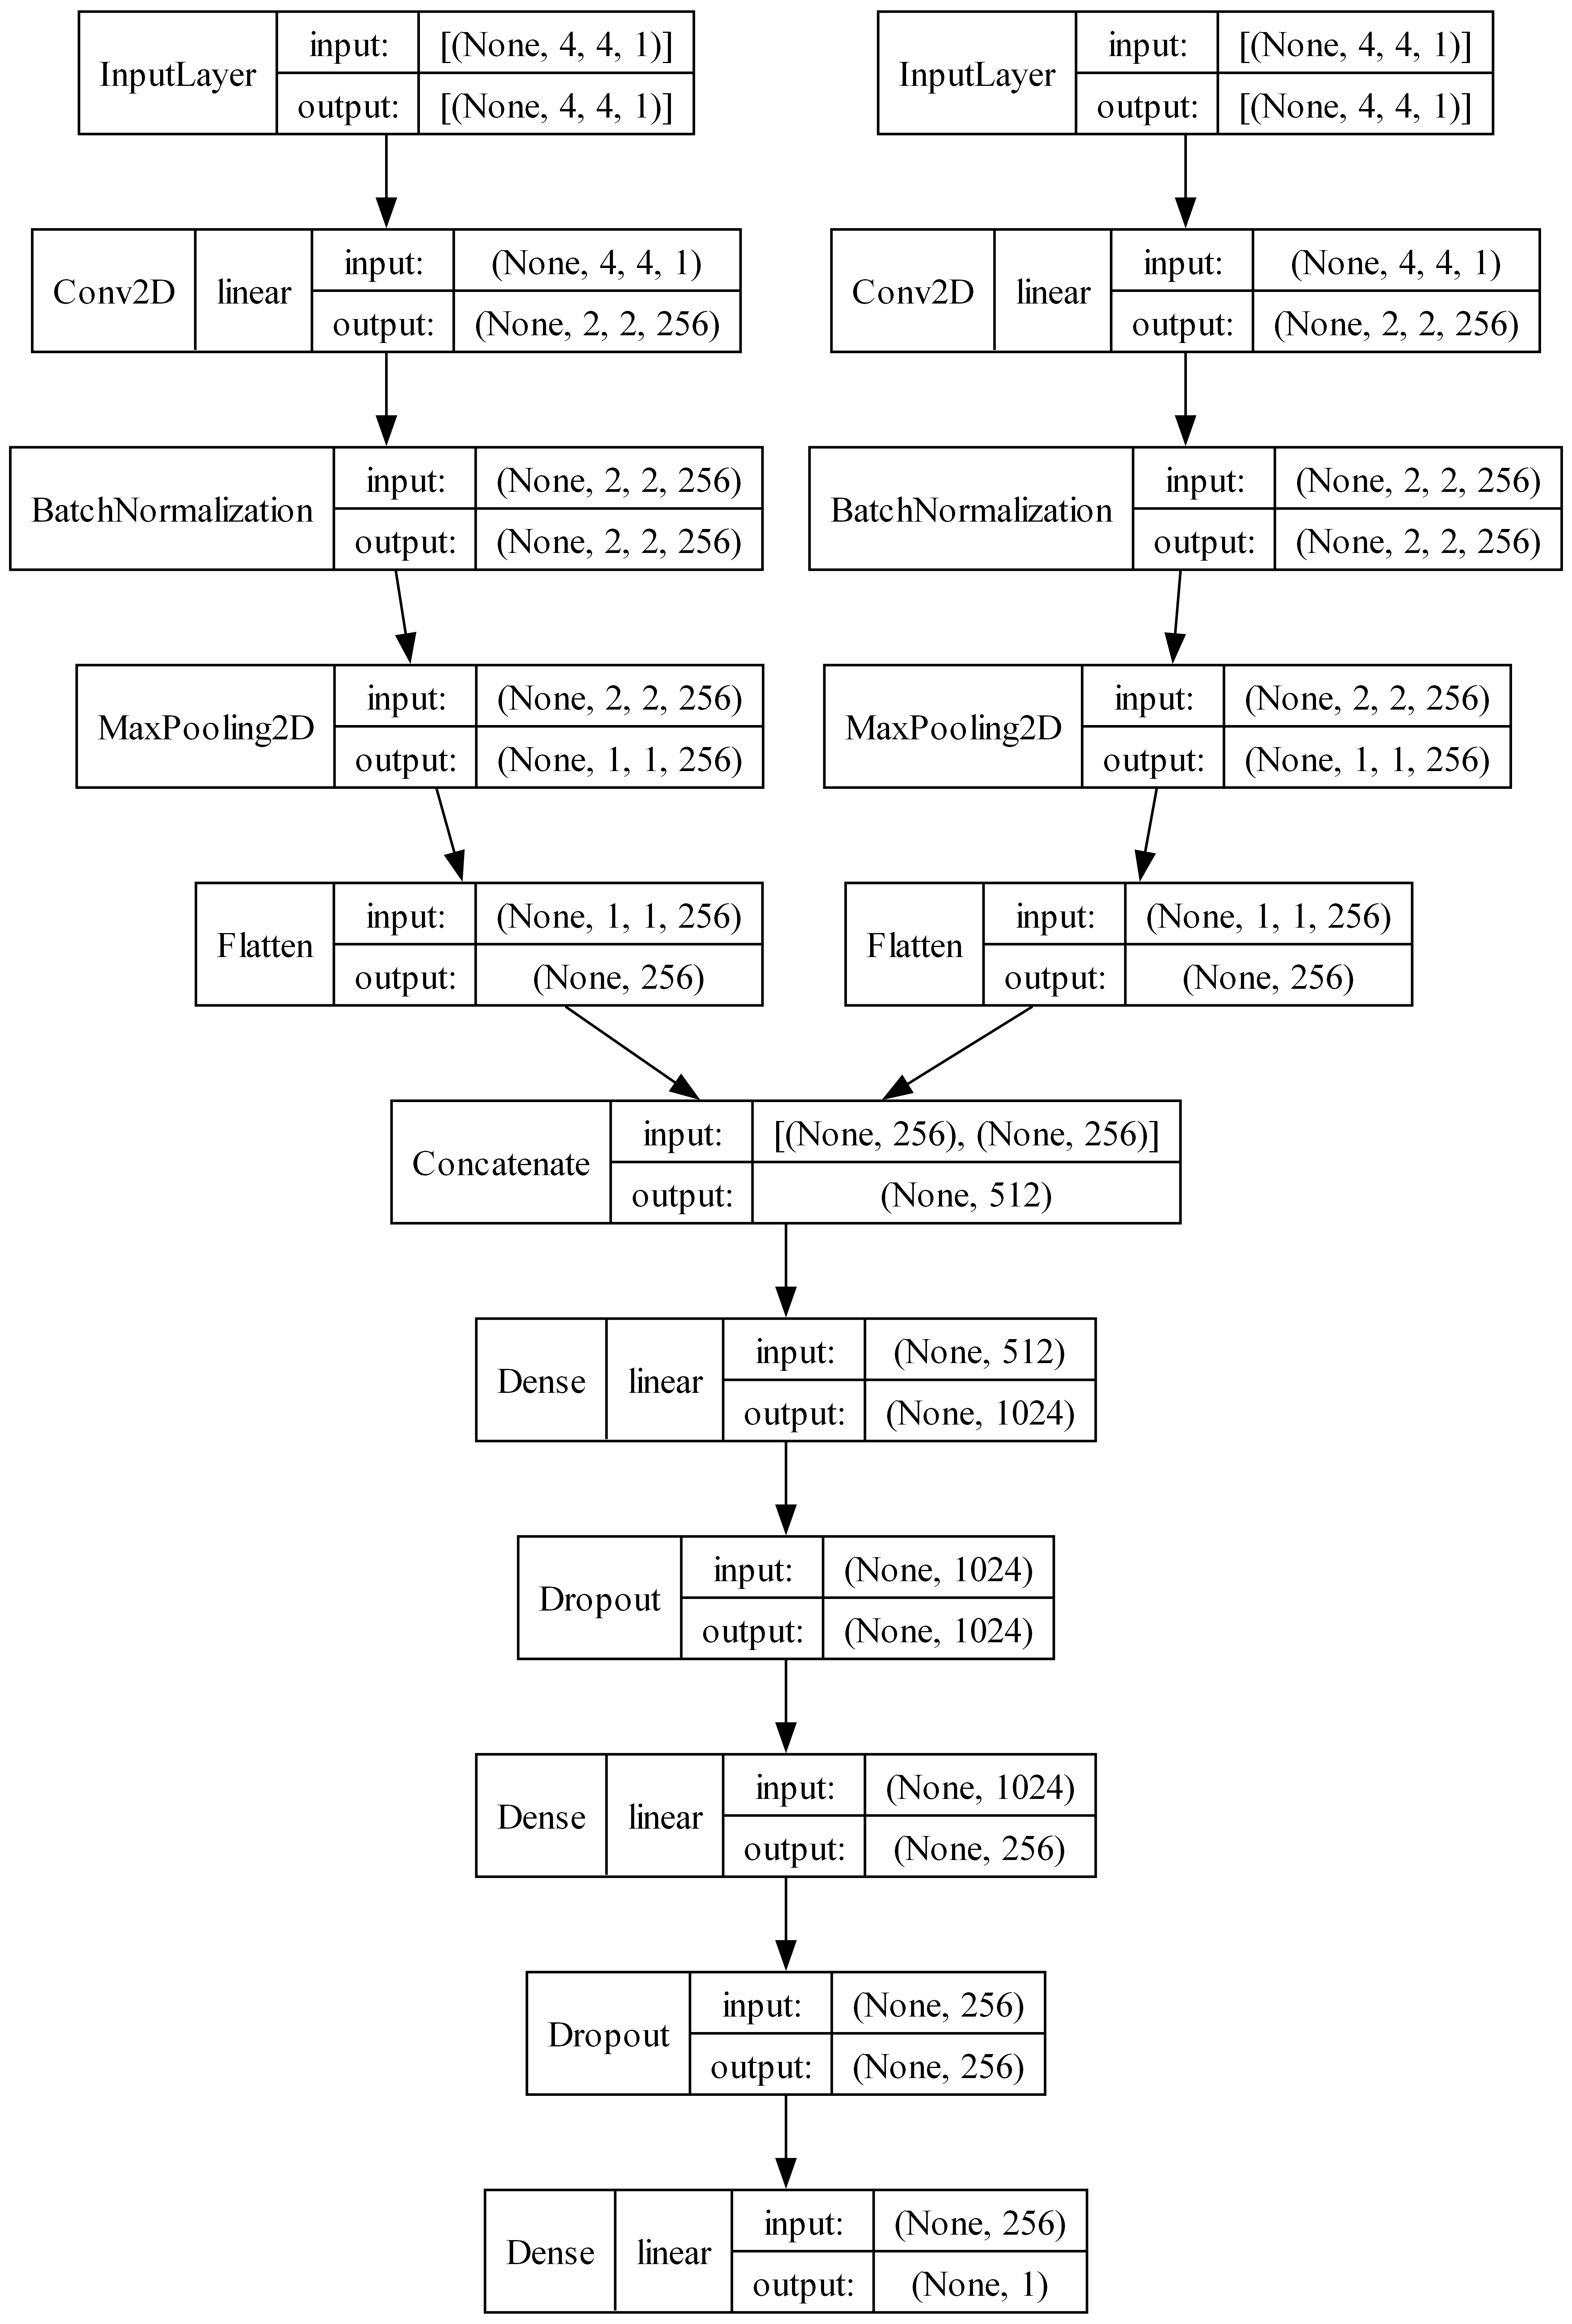

In [7]:
keras.utils.plot_model(
    model, 
    show_layer_names=False,
    show_shapes=True,
    show_layer_activations=True,
    dpi=480
)

In [8]:
import tensorflow as tf
# Train the model
x_train_input = [X_train[:, :, :, 0:1],X_train[:, :, :, 1:2]]
history = model.fit(x_train_input,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )],
                    verbose=2)

Epoch 1/100
362/362 - 6s - loss: 99.6595 - mae: 7.0279 - val_loss: 1126.7136 - val_mae: 29.2518 - 6s/epoch - 15ms/step
Epoch 2/100
362/362 - 4s - loss: 62.6937 - mae: 5.8069 - val_loss: 23.1971 - val_mae: 3.4601 - 4s/epoch - 12ms/step
Epoch 3/100
362/362 - 4s - loss: 53.8706 - mae: 5.3226 - val_loss: 28.1563 - val_mae: 3.7261 - 4s/epoch - 12ms/step
Epoch 4/100
362/362 - 5s - loss: 48.8092 - mae: 5.0452 - val_loss: 20.8880 - val_mae: 2.8909 - 5s/epoch - 13ms/step
Epoch 5/100
362/362 - 4s - loss: 44.9501 - mae: 4.8223 - val_loss: 23.3275 - val_mae: 3.6304 - 4s/epoch - 12ms/step
Epoch 6/100
362/362 - 4s - loss: 47.2353 - mae: 4.9444 - val_loss: 48.2046 - val_mae: 6.0727 - 4s/epoch - 11ms/step
Epoch 7/100
362/362 - 4s - loss: 43.9341 - mae: 4.7061 - val_loss: 16.5000 - val_mae: 2.5670 - 4s/epoch - 12ms/step
Epoch 8/100
362/362 - 4s - loss: 42.7545 - mae: 4.6753 - val_loss: 25.8810 - val_mae: 4.0263 - 4s/epoch - 12ms/step
Epoch 9/100
362/362 - 4s - loss: 45.0122 - mae: 4.8286 - val_loss: 15

In [9]:
# Evaluate the model on the test set
x_test_input = [X_test[:, :, :, 0:1],X_test[:, :, :, 1:2]]
loss, mae = model.evaluate(x_test_input, y_test)
print(f'Test Mean Absolute Error: {mae}')

114/114 [==============================] - 0s 2ms/step - loss: 14.4557 - mae: 2.4339
Test Mean Absolute Error: 2.4338877201080322


In [10]:
# Predictions on the test set
predictions = model.predict(x_test_input)

114/114 [==============================] - 0s 2ms/step


In [11]:
print("|Estimated| x |Actual| x |diff|")
for i in range(len(predictions)):
    print(f'|{int(predictions[i])}|,|{y_test[i]} | {abs(y_test[i]-int(predictions[i]))}')

#Adicionar ruido (mais de um tipo (-140 a -100db)), estimar 20 entradas de cada angulo e 

|Estimated| x |Actual| x |diff|
|10|,|7 | 3
|51|,|51 | 0
|87|,|90 | 3
|29|,|29 | 0
|87|,|90 | 3
|75|,|82 | 7
|6|,|3 | 3
|20|,|23 | 3
|60|,|61 | 1
|9|,|4 | 5
|59|,|54 | 5
|69|,|83 | 14
|10|,|11 | 1
|28|,|29 | 1
|27|,|27 | 0
|81|,|75 | 6
|64|,|64 | 0
|31|,|32 | 1
|66|,|81 | 15
|40|,|39 | 1
|12|,|10 | 2
|66|,|88 | 22
|28|,|27 | 1
|78|,|84 | 6
|25|,|24 | 1
|47|,|47 | 0
|49|,|48 | 1
|8|,|3 | 5
|52|,|53 | 1
|37|,|38 | 1
|11|,|8 | 3
|4|,|0 | 4
|11|,|7 | 4
|77|,|83 | 6
|59|,|60 | 1
|88|,|82 | 6
|86|,|79 | 7
|17|,|19 | 2
|67|,|81 | 14
|23|,|24 | 1
|27|,|25 | 2
|19|,|21 | 2
|28|,|30 | 2
|27|,|25 | 2
|61|,|57 | 4
|41|,|40 | 1
|4|,|0 | 4
|56|,|58 | 2
|81|,|81 | 0
|11|,|12 | 1
|39|,|40 | 1
|60|,|62 | 2
|28|,|27 | 1
|84|,|77 | 7
|71|,|79 | 8
|55|,|57 | 2
|27|,|25 | 2
|44|,|44 | 0
|87|,|87 | 0
|16|,|16 | 0
|45|,|47 | 2
|90|,|84 | 6
|59|,|56 | 3
|28|,|28 | 0
|67|,|67 | 0
|80|,|75 | 5
|16|,|16 | 0
|85|,|79 | 6
|5|,|2 | 3
|8|,|3 | 5
|36|,|34 | 2
|65|,|85 | 20
|25|,|23 | 2
|63|,|63 | 0
|34|,|36 | 2
|15|,

C:\Users\Marli\AppData\Local\Temp\ipykernel_10192\498507051.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'|{int(predictions[i])}|,|{y_test[i]} | {abs(y_test[i]-int(predictions[i]))}')


In [12]:
len(set([int(predictions[j]) for j in range(len(predictions))]))

C:\Users\Marli\AppData\Local\Temp\ipykernel_10192\3110605697.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  len(set([int(predictions[j]) for j in range(len(predictions))]))


93

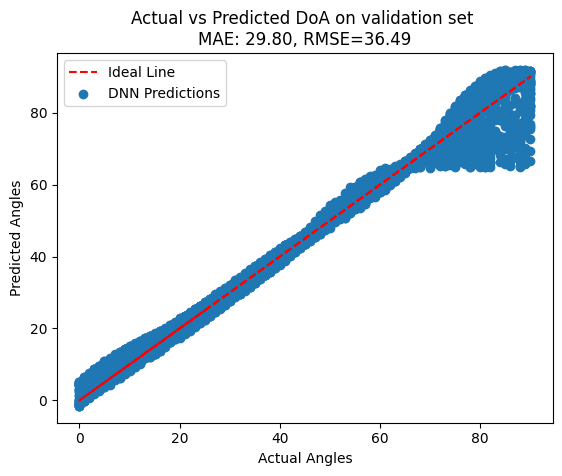

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

# Visualize predictions
# correlation_coefficient, p_value = pearsonr(y_test, predictions)
mae = np.mean(np.abs(np.array(y_test) - np.array(predictions)))
MSE = np.square(np.subtract(y_test,predictions)).mean() 
RMSE = math.sqrt(MSE)
plt.title(f'Actual vs Predicted DoA on validation set \nMAE: {mae:.2f}, {RMSE=:.2f}')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Ideal Line')
plt.scatter(y_test, predictions, label='DNN Predictions')
plt.xlabel('Actual Angles')
plt.ylabel('Predicted Angles')
plt.legend()
plt.show()

In [20]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient
correlation, _ = pearsonr(y_test, predictions.flatten())
print(f'Correlation Coefficient: {correlation}')

Correlation Coefficient: 0.9897525315428556


In [21]:
# Set dataset path variable
validation_signals_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Signalsbluetooth_signals_dataset_2024-03-08_01-04-12.csv"
)
# Set dataset path variable
validation_angles_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Anglesbluetooth_signals_dataset_2024-03-08_01-04-12.csv"
)
# Load dataset
validation_signal_dataset = pd.read_csv(validation_signals_dataset_path, header=None)
signals_validation_dataset_transposed = validation_signal_dataset.transpose()

validation_angles_dataset = pd.read_csv(validation_angles_dataset_path, header=None)

validation_data = result_df = pd.concat([validation_angles_dataset, signals_validation_dataset_transposed], axis=1)

#split data by angle:

# Split the dataframe into multiple dataframes based on the unique values in the first column
unique_angles = validation_data.iloc[:, 0].unique()

# Create a dictionary to store the individual dataframes
angle_dataframes = {}

# Iterate over unique angles and create dataframes
for angle in unique_angles:
    angle_dataframes[angle] = validation_data[validation_data.iloc[:, 0] == angle].copy()

In [22]:
x_train_input[0].shape

(14480, 4, 4, 1)

In [23]:
angle_predictions = {}
for angle, angle_data in angle_dataframes.items():
    # Extract features (IQ samples) and labels (Angles)
    validation_X_complex_str = angle_data.iloc[:, 1:].values.astype(str)
    # Replace 'i' with 'j'
    validation_X_complex_str = np.char.replace(validation_X_complex_str, 'i', 'j')
    # Convert to np.complex128
    validation_X_complex_linear = validation_X_complex_str.astype(np.complex128)
    validation_X_complex = validation_X_complex_linear.reshape((validation_X_complex_linear.shape[0],4,4))

    # Separate real and imaginary parts for features
    validation_X_cov_real = np.real(validation_X_complex)
    validation_X_cov_imag = np.imag(validation_X_complex)

    # Combine real and imaginary parts into a single array for features
    validation_X_cov_combined = np.stack((validation_X_cov_real, validation_X_cov_imag), axis=-1)

    validation_x_input = [validation_X_cov_combined[:, :, :, 0:1],validation_X_cov_combined[:, :, :, 1:2]]
    angle_predictions.update({angle:np.mean(model.predict(validation_x_input))})
    
    # angle_dataframes.update({'prediction':np.mean(angle_predictions)})

1/1 [==============================] - 0s 20ms/step


In [24]:
print(angle_predictions)

{10: 11.883851, 11: 12.20233, 12: 13.534842, 13: 14.89779, 14: 16.193575, 15: 16.88181, 16: 17.388714, 17: 18.675669, 18: 19.228035, 19: 20.431927, 20: 20.920715, 21: 21.861713, 22: 23.042715, 23: 23.334236, 24: 24.495205, 25: 25.680876, 26: 26.568705, 27: 27.674612, 28: 28.233103, 29: 29.236708, 30: 30.490751, 31: 31.539896, 32: 32.613823, 33: 33.76948, 34: 34.441006, 35: 35.00726, 36: 36.35754, 37: 37.1177, 38: 38.18984, 39: 39.154076, 40: 40.194256, 41: 41.331066, 42: 41.689945, 43: 42.935753, 44: 44.02012, 45: 45.316925, 46: 46.092983, 47: 47.01971, 48: 48.525772, 49: 49.11113, 50: 50.123688, 51: 51.524017, 52: 51.986595, 53: 53.1311, 54: 54.30458, 55: 55.1177, 56: 56.500225, 57: 57.21756, 58: 58.201447, 59: 59.404835, 60: 60.20041, 61: 61.054234, 62: 61.828487, 63: 62.89528, 64: 64.17868, 65: 64.80636, 66: 66.07171, 67: 67.01523, 68: 67.74884, 69: 69.47292, 70: 69.66503, 71: 70.42813, 72: 70.95321, 73: 72.63986, 74: 74.36765, 75: 75.02083, 76: 74.516754, 77: 76.82771, 78: 76.02997

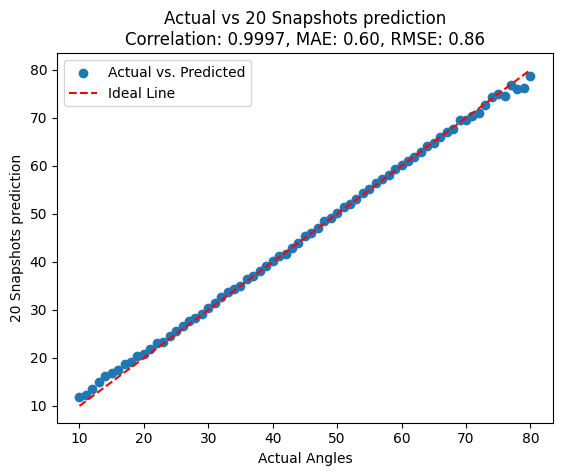

In [25]:
# Calculate the Pearson correlation coefficient and the mean absolute
MSE = np.square(np.subtract(list(angle_predictions.keys()),list(angle_predictions.values()))).mean() 
RMSE = math.sqrt(MSE)
correlation_coefficient, p_value = pearsonr(list(angle_predictions.keys()), list(angle_predictions.values()))
mae = np.mean(np.abs(np.array(list(angle_predictions.keys())) - np.array(list(angle_predictions.values()))))
# Visualize predictions
plt.scatter(list(angle_predictions.keys()), list(angle_predictions.values()), label='Actual vs. Predicted')
plt.title(f'Actual vs 20 Snapshots prediction\nCorrelation: {correlation_coefficient:.4f}, MAE: {mae:.2f}, RMSE: {RMSE:.2f}')
plt.plot(angle_predictions.keys(), angle_predictions.keys(), color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual Angles')
plt.ylabel('20 Snapshots prediction')
plt.legend()
plt.show()

In [26]:

# Print the result
print("Pearson Correlation Coefficient:", correlation_coefficient)
# Print the result
print("Mean Absolute Error:", mae)

Pearson Correlation Coefficient: 0.9996939975534519
Mean Absolute Error: 0.6010254067434392
